<a href="https://colab.research.google.com/github/AshnakAGQ/DistractedDriver/blob/master/CS175Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

##Tensorflow

In [100]:
!pip install tf-nightly
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

In [2]:
print(tf.__version__)

2.3.0-dev20200610


##Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##Kaggle

In [4]:
!pip install kaggle
import os # Sets the environment variables in the root folder 
os.environ['KAGGLE_USERNAME'] = "unorna"
os.environ['KAGGLE_KEY'] = "0a21e3dad74e374d7054ac533a76ede3"
import kaggle
kaggle.api.authenticate()
kaggle.api.competition_download_files('state-farm-distracted-driver-detection', path = 'data/DistractedDriver')
!unzip -q data/DistractedDriver/state-farm-distracted-driver-detection.zip  #unzips kaggle data into content/data

#Import image data


In [5]:
image_size = (224, 224) #image size for image net is 224 x 224 x 3
batch_size = 32

full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "imgs/train",
    image_size = image_size,
    batch_size = batch_size,
    shuffle = False
)

full_ds_s = tf.keras.preprocessing.image_dataset_from_directory(
    "imgs/train",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "imgs/train",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
    subset = 'training',
    validation_split = 0.2,
    shuffle = True
).prefetch(tf.data.experimental.AUTOTUNE)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "imgs/train",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
    subset = 'validation',
    validation_split = 0.2,
    shuffle = True
).prefetch(tf.data.experimental.AUTOTUNE)

Found 22424 files belonging to 10 classes.
Found 22424 files belonging to 10 classes.
Found 22424 files belonging to 10 classes.
Using 17940 files for training.
Found 22424 files belonging to 10 classes.
Using 4484 files for validation.


##View Data

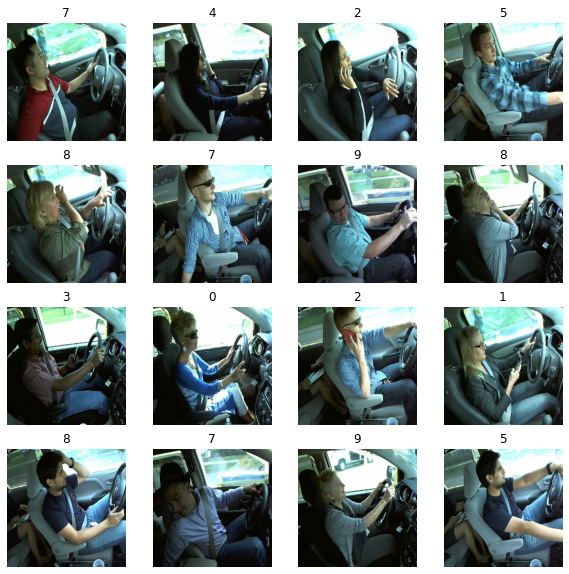

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in full_ds_s.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

#Cross-Validation

In [0]:
def crossvalidate(dataset, n_splits):

  """
  Given a dataset, splits it into {n_splits} subsets, where for 
  any given index, train_ds[i] contains all the subsets except 
  the portion in val_ds[i]

  Parameters
  ----------
  dataset : tensorflow.data.dataset
      Full dataset to split
    
  n_splits : int
      Number of splits; XFold # (at least 2 or greater)
      
  Returns
  -------
  train_ds : list (dtype=ConcatenateDataset)
      List of datasets not containing the ith portion of data
      
  val_ds : list (dtype=ShardDataset)
      List of datasets containing the ith portion of data
  
  """
  
  # Initialize lists
  val_ds = []
  train_ds = []

  # Create val_ds first
  for i in range(n_splits):
    val_ds.append(dataset.shard(num_shards=n_splits, index=i))

  # Create train_ds using val_ds indexes other than the current index
  for i in range(n_splits):
    if i == 0:
      train_ds.append(val_ds[1])
    else:
      train_ds.append(val_ds[0])
    for a in range(1, i):
      train_ds[i] = train_ds[i].concatenate(val_ds[a])
    for b in range(i+1, n_splits):
      if not(i==0 and b==1):
        train_ds[i] = train_ds[i].concatenate(val_ds[b])

  return train_ds, val_ds

In [53]:
n_splits = 5

cv_training_ds, cv_val_ds = crossvalidate(full_ds, n_splits)

print(len(cv_training_ds), cv_training_ds[0])
print(len(cv_val_ds), cv_val_ds[0])

print(tf.data.experimental.cardinality(full_ds))
print(tf.data.experimental.cardinality(cv_training_ds[1]))
print(tf.data.experimental.cardinality(train_ds))
print(tf.data.experimental.cardinality(cv_val_ds[1]))
print(tf.data.experimental.cardinality(validation_ds))

5 <ConcatenateDataset shapes: ((None, 224, 224, None), (None,)), types: (tf.float32, tf.int32)>
5 <ShardDataset shapes: ((None, 224, 224, None), (None,)), types: (tf.float32, tf.int32)>
tf.Tensor(701, shape=(), dtype=int64)
tf.Tensor(561, shape=(), dtype=int64)
tf.Tensor(561, shape=(), dtype=int64)
tf.Tensor(140, shape=(), dtype=int64)
tf.Tensor(141, shape=(), dtype=int64)


#Model Testing

In [0]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode ='min', patience=4),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True)
]
inception_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode ='min', patience=4),
    tf.keras.callbacks.ModelCheckpoint(filepath='inceptionmodel.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True)
]

##VGG16

###Summary

In [113]:
VGGnet = VGG16(include_top=False,weights='imagenet', input_shape=(224,224,3))
flatten = Flatten()(VGGnet.outputs[-1])
VGGnet = Model(inputs=VGGnet.inputs,outputs=flatten)
for layer in VGGnet.layers:
    layer.trainable = False
VGGnet.summary()

model = Sequential()
model.add(VGGnet)
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "functional_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [0]:
# model.save_weights('drive/My Drive/my_model_weights.h5') # Save the current model into Google Drive

###Testing

In [0]:
def VGG_preprocess(image,score):
  newimage = keras.applications.vgg16.preprocess_input(image)
  if score is None:
        return newimage
  else:
        return newimage, score

accuracies = []
losses = []

for i in range(len(cv_training_ds)):

  # Pre-processing
  train = cv_training_ds[i].map(VGG_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  train = train.prefetch(tf.data.experimental.AUTOTUNE)
  val = cv_val_ds[i].map(VGG_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  val = val.prefetch(tf.data.experimental.AUTOTUNE)

  model = Sequential()
  model.add(VGGnet)
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='softmax'))

  # Might have to copy data from Google Drive to the Google Environment
  model.compile(optimizer=keras.optimizers.SGD(lr=0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
  model.fit(train, epochs=10, validation_data=val, callbacks=my_callbacks)

  # Generate generalization metrics
  scores = model.evaluate(val, verbose=0)
  accuracies.append(scores[1] * 100)
  losses.append(scores[0])

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracies)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {losses[i]} - Accuracy: {accuracies[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracies)} (+- {np.std(accuracies)})')
print(f'> Loss: {np.mean(losses)}')
print('------------------------------------------------------------------------')

Epoch 1/10
560/560 [==============================] - 320s 571ms/step - loss: 2.8368 - accuracy: 0.9213 - val_loss: 5.4233 - val_accuracy: 0.1330
Epoch 2/10
119/560 [=====>........................] - ETA: 3:20 - loss: 0.3403 - accuracy: 0.9252

##Resnet

###Summary

In [99]:
resnet_model = ResNet50(include_top =False,weights='imagenet', input_shape=(320,240,3))
resnet_flatten = Flatten()(resnet_model.outputs[-1])
resnet_output = Dense(10, activation = 'softmax')(resnet_flatten)
resnet_model = Model(inputs=resnet_model.inputs,outputs=resnet_output)
resnet_model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 320, 240, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 246, 3)  0           input_19[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 160, 120, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 160, 120, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

###Testing

In [0]:
accuracies = []
losses = []

for i in range(len(cv_training_ds)):
  resnet_model = ResNet50(include_top =False,weights='imagenet', input_shape=(320,240,3))
  resnet_flatten = Flatten()(resnet_model.outputs[-1])
  resnet_output = Dense(10, activation = 'softmax')(resnet_flatten)
  resnet_model = Model(inputs=resnet_model.inputs,outputs=resnet_output)

  resnet_model.compile(optimizer='nadam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
  resnet_model.fit(cv_training_ds[i], epochs=10, validation_data=cv_val_ds[i], callbacks=my_callbacks)

  # Generate generalization metrics
  scores = resnet_model.evaluate(cv_val_ds[i], verbose=0)
  accuracies.append(scores[1] * 100)
  losses.append(scores[0])

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracies)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {losses[i]} - Accuracy: {accuracies[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracies)} (+- {np.std(accuracies)})')
print(f'> Loss: {np.mean(losses)}')
print('------------------------------------------------------------------------')

##Inception

###Summary

In [0]:
inception_model = InceptionV3(include_top =False,weights='imagenet', input_shape=(320,240,3))
inception_flatten = Flatten()(inception_model.outputs[-1])
inception_output = Dense(10, activation = 'softmax')(inception_flatten)
inception_model = Model(inputs=inception_model.inputs,outputs=inception_output)
inception_model.summary()

###Testing

In [25]:
accuracies = []
losses = []

for i in range(len(cv_training_ds)):
  inception_model = InceptionV3(include_top =False,weights='imagenet', input_shape=(224,224,3))
  inception_flatten = Flatten()(inception_model.outputs[-1])
  inception_output = Dense(10, activation = 'softmax')(inception_flatten)
  inception_model = Model(inputs=inception_model.inputs,outputs=inception_output)

  inception_model.compile(optimizer='nadam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
  inception_model.fit(cv_training_ds[i], epochs=10, validation_data=cv_val_ds[i], callbacks=inception_callbacks)

  # Generate generalization metrics
  scores = inception_model.evaluate(cv_val_ds[i], verbose=0)
  accuracies.append(scores[1] * 100)
  losses.append(scores[0])

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracies)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {losses[i]} - Accuracy: {accuracies[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracies)} (+- {np.std(accuracies)})')
print(f'> Loss: {np.mean(losses)}')
print('------------------------------------------------------------------------')

Epoch 1/10
280/560 [==============>...............] - ETA: 1:37 - loss: 2.9883 - accuracy: 0.0993

KeyboardInterrupt: ignored

In [0]:
#inception_model.save("drive/My Drive/inceptionv3_model.h5")

#Other

In [0]:
# it = iter(full_ds) # Dataset iterable
# images = next(it)[0].numpy() # Get first batch of images
# images = preprocess_input(images) # Preprocess images. Not sure if this necessary or not

# yhat = model.predict(images)